In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
Y_train = pd.read_csv('../data/Y_train.csv')
Y_test = pd.read_csv('../data/Y_test.csv')

FS_DT = pd.read_csv('../data/FS_decision_tree.csv').values.flatten()
FS_RF = pd.read_csv('../data/FS_random_forest.csv').values.flatten()

# Decision Tree Regression

Alleniamo il modello e illustriamo in un grafico l'andamento del Mean Squared Error del dataset di train e del dataset di test al variare dell'iper-parametro max_leaf_nodes del modello DecisionTreeRegressor.

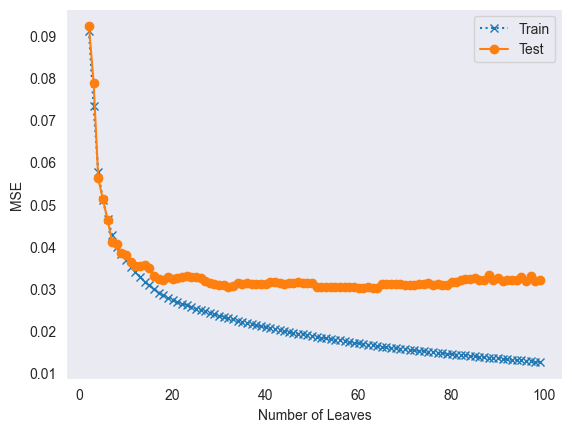

In [2]:
errors = []

for max_leaves in range(2,100):
    # train and predict
    dt = DecisionTreeRegressor(max_leaf_nodes=max_leaves)
    dt.fit(X_train,Y_train)

    # compute Accuracy
    train_acc = mean_squared_error(y_true=Y_train, y_pred=dt.predict(X_train))
    test_acc  = mean_squared_error(y_true=Y_test,  y_pred=dt.predict(X_test))

    errors += [ [max_leaves, train_acc, test_acc] ]

errors = np.array(errors)

fig, ax = plt.subplots()
ax.plot(errors[:,0], errors[:,1], "x:", label="Train")
ax.plot(errors[:,0], errors[:,2], "o-", label="Test")
ax.set_ylabel("MSE")
ax.set_xlabel("Number of Leaves")
ax.grid()
ax.legend();

Andiamo ora ad usare la GridSearchCV per allenare il modello andado a fare tuning dei parametri del modello.

In [3]:
parameters = {'criterion': ['squared_error', 'friedman_mse'],
              'max_depth': [None, 50, 60, 100],
              'min_samples_split': [2, 3],
              'min_samples_leaf': [1, 2, 3],
              'max_leaf_nodes': [None, 20, 50, 70, 100]}

dt = DecisionTreeRegressor()
tuned_model = GridSearchCV(dt, parameters, cv=5, verbose=0, n_jobs=-1)
tuned_model.fit(X_train, Y_train.values.ravel())

print ("Best Score: {:.3f}".format(tuned_model.best_score_) )
print ("Best Params: ", tuned_model.best_params_)

train_pre = tuned_model.predict(X_train)
test_pre = tuned_model.predict(X_test)

print("Train MSE: {:.3f}".format((mean_squared_error(y_true=np.exp(Y_train),
                                                     y_pred=np.exp(train_pre)))))

print("Test MSE: {:.3f}".format((mean_squared_error(y_true=np.exp(Y_test),
                                                    y_pred=np.exp(test_pre)))))

print("Train R^2: {:.3f}".format((r2_score(y_true=np.exp(Y_train),
                                           y_pred=np.exp(train_pre)))))

print("Test R^2: {:.3f}".format((r2_score(y_true=np.exp(Y_test),
                                          y_pred=np.exp(test_pre)))))

Best Score: 0.813
Best Params:  {'criterion': 'friedman_mse', 'max_depth': 100, 'max_leaf_nodes': 70, 'min_samples_leaf': 3, 'min_samples_split': 3}
Train MSE: 610419609.776
Test MSE: 1250860653.975
Train R^2: 0.897
Test R^2: 0.844


Abbiamo che il modello ha un $R^2$ sul test di 0.844, mentre con la GridSearchCV i parametri selezionati sono: {'criterion': 'friedman_mse', 'max_depth': 100, 'max_leaf_nodes': 70, 'min_samples_leaf': 3, 'min_samples_split': 3}.

Ora andiamo a creare un plot in cui sull’asse delle ordinate abbiamo il prezzo originale, mentre sull’asse delle ordinate abbiamo il prezzo predetto. Abbiamo che le istanze blu sono quelle del Train, mentre quelle rosse sono quelle del Test. Ciò è utile per vedere visivamente di quanto si disconta la predizioni dal prezzo reale.

Text(0, 0.5, 'Sale_Price')

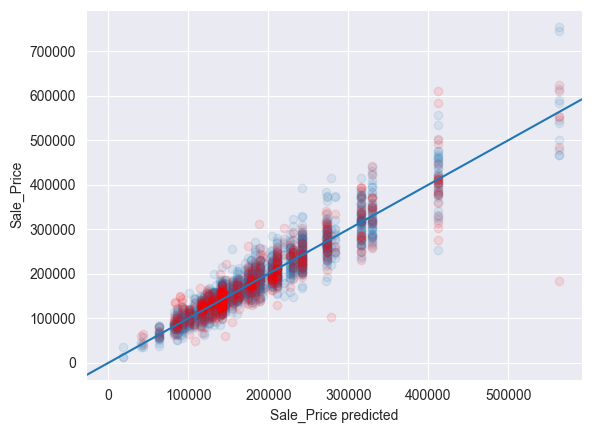

In [4]:
fig, axs = plt.subplots()

axs.plot(np.exp(train_pre), np.exp(Y_train), 'o', alpha=0.1)
axs.plot(np.exp(test_pre), np.exp(Y_test), 'o', alpha=0.1, c="red")
axs.axline((0, 0), slope=1)
axs.set_xlabel('Sale_Price predicted')
axs.set_ylabel('Sale_Price')

Dal grafico possiamo notare come il modello stia andando a creare dei valori di prezzo e vada ad inserire l'istanza in quel valore.

# Bagging

Nel tentativo di ottenere performance migliori applichiamo il metodo ensamble bagging

In [5]:
from sklearn.ensemble import BaggingRegressor

dt = DecisionTreeRegressor(criterion='squared_error', max_depth=60, max_leaf_nodes=70, min_samples_leaf=3, min_samples_split=3)
boosted_dt = BaggingRegressor(dt, n_estimators=1000)
boosted_dt.fit(X_train, Y_train.values.ravel())
test_pre = boosted_dt.predict(X_test)
train_pre = boosted_dt.predict(X_train)

print("Train MSE: {:.3f}".format((mean_squared_error(y_true=np.exp(Y_train),
                                                     y_pred=np.exp(train_pre)))))

print("Test MSE: {:.3f}".format((mean_squared_error(y_true=np.exp(Y_test),
                                                    y_pred=np.exp(test_pre)))))

print("Train R^2: {:.3f}".format((r2_score(y_true=np.exp(Y_train),
                                           y_pred=np.exp(train_pre)))))

print("Test R^2: {:.3f}".format((r2_score(y_true=np.exp(Y_test),
                                          y_pred=np.exp(test_pre)))))

Train MSE: 388965597.822
Test MSE: 833122617.796
Train R^2: 0.935
Test R^2: 0.896


Con il Bagging abbiamo un leggere miglioramento delle prestazioni in quanto arriviamo ad un $R^2$ di 0.896 sul test.
Andiamo a creare rifare il grafico il precedentemente creato.

Text(0, 0.5, 'Sale_Price')

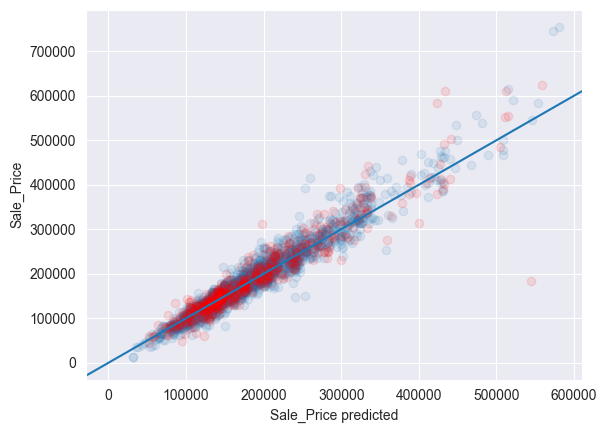

In [6]:
fig, axs = plt.subplots()

axs.plot(np.exp(train_pre), np.exp(Y_train), 'o', alpha=0.1)
axs.plot(np.exp(test_pre), np.exp(Y_test), 'o', alpha=0.1, c="red")
axs.axline((0, 0), slope=1)
axs.set_xlabel('Sale_Price predicted')
axs.set_ylabel('Sale_Price')

Possiamo notare come la divisione per valori di prezzo non sia più presente, questo deriva dalle caratteristiche del bagging che ci permette una migliore previsione del prezzo grazie all'utilizzo di più alberi.

# Boosting

Nel tentativo di ottenere performance migliori applichiamo il metodo ensamble di boosting AdaBoost.

In [7]:
from sklearn.ensemble import AdaBoostRegressor

dt = DecisionTreeRegressor(criterion='squared_error', max_depth=60, max_leaf_nodes=70, min_samples_leaf=3, min_samples_split=3)
boosted_dt = AdaBoostRegressor(dt, n_estimators=1000)
boosted_dt.fit(X_train, Y_train.values.ravel())
test_pre = boosted_dt.predict(X_test)
train_pre = boosted_dt.predict(X_train)

print("Train MSE: {:.3f}".format((mean_squared_error(y_true=np.exp(Y_train),
                                                     y_pred=np.exp(train_pre)))))

print("Test MSE: {:.3f}".format((mean_squared_error(y_true=np.exp(Y_test),
                                                    y_pred=np.exp(test_pre)))))

print("Train R^2: {:.3f}".format((r2_score(y_true=np.exp(Y_train),
                                           y_pred=np.exp(train_pre)))))

print("Test R^2: {:.3f}".format((r2_score(y_true=np.exp(Y_test),
                                          y_pred=np.exp(test_pre)))))

Train MSE: 206504546.135
Test MSE: 801874347.560
Train R^2: 0.965
Test R^2: 0.900


Possiamo notare come le prestazioni siano ancora migliorate arrivando ad un $R^2$ di 0.900

Text(0, 0.5, 'Sale_Price')

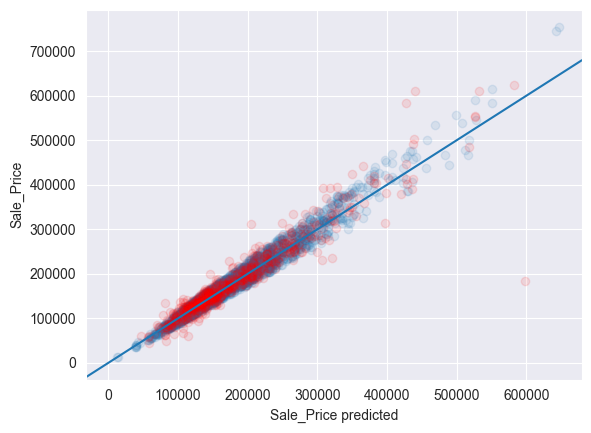

In [8]:
fig, axs = plt.subplots()

axs.plot(np.exp(train_pre), np.exp(Y_train), 'o', alpha=0.1)
axs.plot(np.exp(test_pre), np.exp(Y_test), 'o', alpha=0.1, c="red")
axs.axline((0, 0), slope=1)
axs.set_xlabel('Sale_Price predicted')
axs.set_ylabel('Sale_Price')

## Proviamo a ridurre le features usando quelle ricavate nel notebook data-engineering
Per provare ad andare a migliorare le prestazioni del modello andiamo ad usare il dataset dopo aver ridotto le features tramite l'uso della *RFECV* di sklern. Alleneremo solo AdaBoost in quanto è risultato il modello con l'$R^2$ più alto.

In [9]:
dt = DecisionTreeRegressor(criterion='squared_error', max_depth=60, max_leaf_nodes=70, min_samples_leaf=3, min_samples_split=3)
boosted_dt = AdaBoostRegressor(dt, n_estimators=1000)
boosted_dt.fit(X_train[FS_DT], Y_train.values.ravel())
test_pre = boosted_dt.predict(X_test[FS_DT])
train_pre = boosted_dt.predict(X_train[FS_DT])

print("Train MSE: {:.3f}".format((mean_squared_error(y_true=np.exp(Y_train),
                                                     y_pred=np.exp(train_pre)))))

print("Test MSE: {:.3f}".format((mean_squared_error(y_true=np.exp(Y_test),
                                                    y_pred=np.exp(test_pre)))))

print("Train R^2: {:.3f}".format((r2_score(y_true=np.exp(Y_train),
                                           y_pred=np.exp(train_pre)))))

print("Test R^2: {:.3f}".format((r2_score(y_true=np.exp(Y_test),
                                          y_pred=np.exp(test_pre)))))

Train MSE: 209339044.195
Test MSE: 803321518.604
Train R^2: 0.965
Test R^2: 0.900


In [10]:
dt = DecisionTreeRegressor(criterion='squared_error', max_depth=60, max_leaf_nodes=70, min_samples_leaf=3, min_samples_split=3)
boosted_dt = AdaBoostRegressor(dt, n_estimators=1000)
boosted_dt.fit(X_train[FS_RF], Y_train.values.ravel())
test_pre = boosted_dt.predict(X_test[FS_RF])
train_pre = boosted_dt.predict(X_train[FS_RF])

print("Train MSE: {:.3f}".format((mean_squared_error(y_true=np.exp(Y_train),
                                                     y_pred=np.exp(train_pre)))))

print("Test MSE: {:.3f}".format((mean_squared_error(y_true=np.exp(Y_test),
                                                    y_pred=np.exp(test_pre)))))

print("Train R^2: {:.3f}".format((r2_score(y_true=np.exp(Y_train),
                                           y_pred=np.exp(train_pre)))))

print("Test R^2: {:.3f}".format((r2_score(y_true=np.exp(Y_test),
                                          y_pred=np.exp(test_pre)))))

Train MSE: 207245415.908
Test MSE: 798352888.919
Train R^2: 0.965
Test R^2: 0.900


Possiamo vedere come le prestazioni non migliorino con nessuno dei due dataset.